In [ ]:
# 셀 순서대로 진행

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 데이터 로드 및 전처리

In [ ]:
import pandas as pd

# 변수에 사용될 데이터 로드
people = pd.read_csv("/content/drive/MyDrive/데이터청년캠퍼스/모델링/데이터/2022년행정동별버스유동인구_전처리.csv", encoding="UTF-8")
hot = pd.read_csv("/content/drive/MyDrive/데이터청년캠퍼스/모델링/데이터/2022년도_폭염빈도_강도.csv", encoding="UTF-8")
old = pd.read_csv("/content/drive/MyDrive/데이터청년캠퍼스/모델링/데이터/2022년도_만65세이상_거주자.csv", encoding="UTF-8")
young = pd.read_csv("/content/drive/MyDrive/데이터청년캠퍼스/모델링/데이터/2020_2021_2022_만12세이하_전처리.csv", encoding="CP949")
hurt = pd.read_csv("/content/drive/MyDrive/데이터청년캠퍼스/모델링/데이터/2022년도_장애인_전처리.csv", encoding="UTF-8")
air = pd.read_csv("/content/drive/MyDrive/데이터청년캠퍼스/모델링/데이터/2022년도_(초)미세먼지나쁨빈도_전처리.csv", encoding="UTF-8")

In [ ]:
# 데이터별 칼럼명 변경 및 데이터 선택
people.rename(columns={"월평균 총승하차승객수":"월평균_승하차_승객수"}, inplace=True)
people = people[["자치구", "행정동","월평균_승하차_승객수"]]
old.rename(columns={"2022년_만65세이상_인구수":"만65세이상_인구수"}, inplace=True)
young.rename(columns={"2022년12월_거주자_연령구간인구수":"만12세이하_인구수"}, inplace=True)
young = young[["자치구", "행정동", "만12세이하_인구수"]]
hurt["행정동"] = hurt["행정동"].str.replace(".", "·")
hurt.drop(columns=["Unnamed: 0", "합계"], inplace=True)
hurt.rename(columns={"지체":"지체_장애인", "시각":"시각_장애인"}, inplace=True)
air.rename(columns={"(초)미세먼지 나쁨 빈도":"(초)미세먼지_나쁨빈도"}, inplace=True)
air = air[["자치구", "행정동","(초)미세먼지_나쁨빈도"]]

# 데이터 합치기
df = people.merge(old, on=["자치구", "행정동"])
df = df.merge(young, on=["자치구", "행정동"])
df = df.merge(hurt, on=["자치구", "행정동"])
df = df.merge(hot, on=["자치구", "행정동"])
df = df.merge(air, on=["자치구", "행정동"])

# 데이터 분포에 따른 새로운 변수 생성 및 제거
df["교통약자_인구수"] = df["만65세이상_인구수"] + df["만12세이하_인구수"] + df["지체_장애인"] + df["시각_장애인"]
df.drop(columns=["만65세이상_인구수", "만12세이하_인구수", "지체_장애인", "시각_장애인", "폭염강도"], inplace=True)

<ipython-input-4-cdf097143e76>:7: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  hurt["행정동"] = hurt["행정동"].str.replace(".", "·")


## 스케일러 결정

In [ ]:
# 코랩 한글 깨짐 현상 해결
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

<ipython-input-3-fa806c70dc0f>:54: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


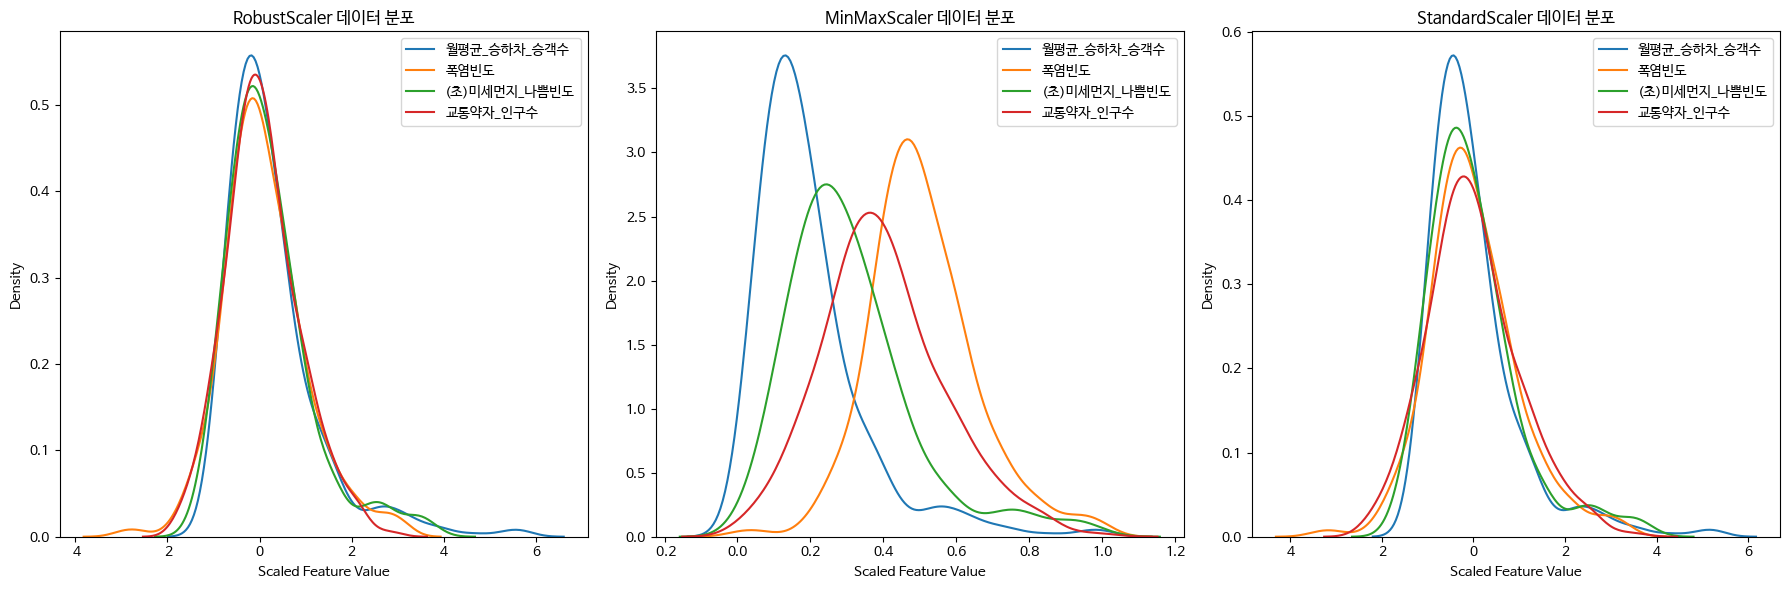

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import RobustScaler, MinMaxScaler, StandardScaler

# feature 생성
data = df.copy()
features = data[["월평균_승하차_승객수", "폭염빈도", "(초)미세먼지_나쁨빈도", "교통약자_인구수"]]

# 데이터 스케일링
robust_scaler = RobustScaler()
minmax_scaler = MinMaxScaler()
standard_scaler = StandardScaler()

robust_scaled_features = robust_scaler.fit_transform(features)
minmax_scaled_features = minmax_scaler.fit_transform(features)
standard_scaled_features = standard_scaler.fit_transform(features)

# 스케일링 후, 데이터프레임 생성
robust_scaled_df = pd.DataFrame(robust_scaled_features, columns=features.columns)
minmax_scaled_df = pd.DataFrame(minmax_scaled_features, columns=features.columns)
standard_scaled_df = pd.DataFrame(standard_scaled_features, columns=features.columns)

# 시각화를 위한 그림 크기 설정 및 글꼴 설정
plt.rcParams['font.family'] = 'NanumBarunGothic'
plt.figure(figsize=(18, 6))

# RobustScaler를 적용한 데이터 분포 시각화
plt.subplot(1, 3, 1)
for column in robust_scaled_df.columns:
    sns.kdeplot(robust_scaled_df[column], label=column)
plt.title('RobustScaler 데이터 분포')
plt.xlabel('Scaled Feature Value')
plt.ylabel('Density')
plt.legend()

# MinMaxScaler를 적용한 데이터 분포 시각화
plt.subplot(1, 3, 2)
for column in minmax_scaled_df.columns:
    sns.kdeplot(minmax_scaled_df[column], label=column)
plt.title('MinMaxScaler 데이터 분포')
plt.xlabel('Scaled Feature Value')
plt.ylabel('Density')
plt.legend()

# StandardScaler를 적용한 데이터 분포 시각화
plt.subplot(1, 3, 3)
for column in standard_scaled_df.columns:
    sns.kdeplot(standard_scaled_df[column], label=column)
plt.title('StandardScaler 데이터 분포')
plt.xlabel('Scaled Feature Value')
plt.ylabel('Density')
plt.legend()

plt.tight_layout()
plt.show()

## 클러스터수 결정

### K-means 클러스터수 결정

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

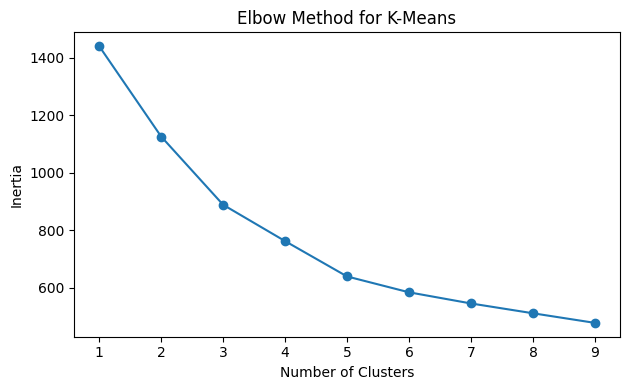

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import RobustScaler

# 데이터 로드 및 행정동, 자치구 컬럼 삭제
data = df.copy()
X = data.drop(["행정동", "자치구"], axis=1)

# RobustScaler로 데이터 스케일 조정
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X)

# 클러스터 개수 후보 범위
cluster_range = range(1, 10)

# Elbow Method를 이용한 K-means 클러스터 개수 탐색
inertia_values = []
for n_clusters in cluster_range:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(X_scaled)
    inertia_values.append(kmeans.inertia_)

# Elbow Method 그래프 시각화
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(cluster_range, inertia_values, marker="o")
plt.title("Elbow Method for K-Means")
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia")

plt.tight_layout()
plt.show()

In [ ]:
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from sklearn.preprocessing import RobustScaler

# 데이터 로드 및 행정동, 자치구 컬럼 삭제
data = df.copy()
X = data.drop(["행정동", "자치구"], axis=1)

# RobustScaler로 데이터 스케일 조정
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X)

# 클러스터 개수 후보 범위 및 변수 생성
cluster_range = range(2, 10)
best_n = 0
best_silhouette_score = 0

# Silhouteet Score를 이용한 K-means 클러스터 개수 탐색
for n_clusters in cluster_range:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster = kmeans.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, cluster)
    if score > best_silhouette_score:
        best_n = n_clusters
        best_silhouette_score = score

print("최적의 클러스터 수 =", best_n, "\nSilhouette Score =", best_silhouette_score)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

최적의 클러스터 수 = 2 
Silhouette Score = 0.2790875018240492


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


### Gaussian Mixsture Mode 클러스터수 결정



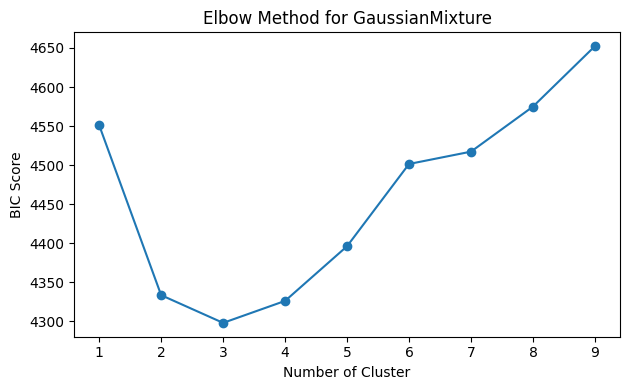

In [ ]:
# Elbow Method
import pandas as pd
import numpy as np
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt

# 데이터 로드 및 행정동, 자치구 컬럼 삭제
data = df.copy()
X = data.drop(["행정동", "자치구"], axis=1)

# RobustScaler로 데이터 스케일 조정
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X)

# 클러스터 개수 후보 범위
cluster_range = range(1, 10)

# Elbow Method를 이용한 GMM 클러스터 개수 탐색
bic_scores = []
for n_components in cluster_range:
    gmm = GaussianMixture(n_components=n_components, random_state=42)
    gmm.fit(X_scaled)
    bic_scores.append(gmm.bic(X_scaled))

# Elbow Method 그래프 시각화
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(cluster_range, bic_scores, marker="o")
plt.title("Elbow Method for GaussianMixture")
plt.xlabel("Number of Cluster")
plt.ylabel("BIC Score")

plt.tight_layout()
plt.show()

In [ ]:
# Silhouetee Score
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score

# 데이터 로드 및 행정동, 자치구 컬럼 삭제
data = df.copy()
X = data.drop(["행정동", "자치구"], axis=1)

# RobustScaler로 데이터 스케일 조정
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X)

# 클러스터 개수 후보 범위 및 변수 생성
cluster_range = range(2, 10)
best_n = 0
best_silhouette_score = 0

# Silhouette Score를 이용한 GMM 클러스터 개수 탐색
for n_clusters in cluster_range:
    gmm = GaussianMixture(n_components=n_clusters, random_state=42)
    gmm.fit(X_scaled)
    clusters = gmm.predict(X_scaled)
    score = silhouette_score(X_scaled, clusters)
    if score > best_silhouette_score:
        best_n = n_clusters
        best_silhouette_score = score

print("최적의 클러스터 수 =", best_n, "\nSilhouette score =", best_silhouette_score)

최적의 클러스터 수 = 2 
Silhouette score = 0.5010881687985597


### Hierarchical K-Means 클러스터수 결정

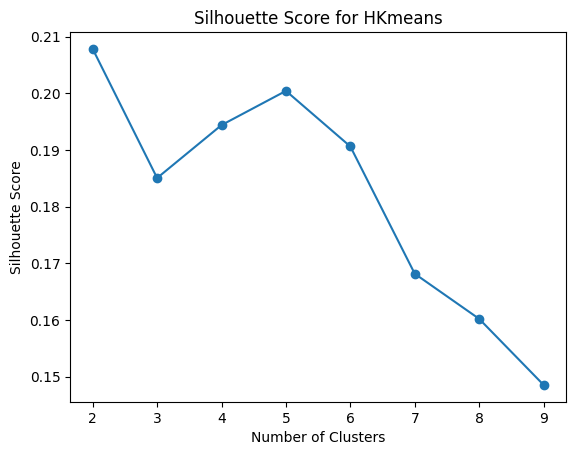


최적의 클러스터 수 = 2 
Silhouette score = 0.2078132829208425


In [ ]:
from sklearn.cluster import AgglomerativeClustering
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import RobustScaler

# 데이터 로드 및 행정동, 자치구 컬럼 삭제
data = df.copy()
X = data.drop(["행정동", "자치구"], axis=1)

# RobustScaler로 데이터 스케일 조정
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X)

# 클러스터 개수 후보 범위 및 변수 생성
cluster_range = range(2, 10)
best_n = 0
best_silhouette_score = 0

# Silhouette Score를 이용한 HKmeans 클러스터 개수 탐색
silhouette_scores = []
for n_clusters in cluster_range:
    clustering = AgglomerativeClustering(n_clusters=n_clusters)
    clusters = clustering.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, clusters)
    silhouette_scores.append(score)
    if score > best_silhouette_score:
        best_n = n_clusters
        best_silhouette_score = score

# Silhouette Score 그래프 시각화
plt.plot(cluster_range, silhouette_scores, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for HKmeans')
plt.show()

print("\n최적의 클러스터 수 =", best_n, "\nSilhouette score =", best_silhouette_score)

### K-Medoids 클러스터수 결정

In [ ]:
!pip install scikit-learn-extra

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 12.8 MB/s eta 0:00:00


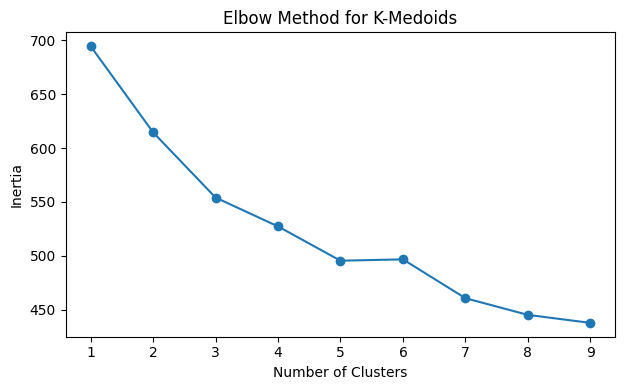

In [ ]:
# Elbow Method
import pandas as pd
import numpy as np
from sklearn_extra.cluster import KMedoids
import matplotlib.pyplot as plt

# 데이터 로드 및 행정동, 자치구 컬럼 삭제
data = df.copy()
X = data.drop(["행정동", "자치구"], axis=1)

# RobustScaler로 데이터 스케일 조정
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X)

# 클러스터 개수 후보 범위
cluster_range = range(1, 10)

# Elbow Method를 이용한 K-Medoids 클러스터 개수 탐색
inertia_values = []
for n_clusters in cluster_range:
    kmedoids = KMedoids(n_clusters=n_clusters, random_state=42)
    kmedoids.fit(X_scaled)
    inertia_values.append(kmedoids.inertia_)

# Elbow Method 그래프 시각화
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(cluster_range, inertia_values, marker="o")
plt.title("Elbow Method for K-Medoids")
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia")

plt.tight_layout()
plt.show()

In [ ]:
from sklearn_extra.cluster import KMedoids
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import RobustScaler

# 데이터 로드 및 행정동, 자치구 컬럼 삭제
data = df.copy()
data = data.drop(["행정동", "자치구"], axis=1)

# RobustScaler로 데이터 스케일 조정
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X)

# 클러스터 개수 후보 범위 및 변수 생성
cluster_range = range(2, 10)
best_n = 0
best_silhouette_score = 0

# Silhouette Score를 이용한 K-Medoids 클러스터 개수 탐색
for n_clusters in cluster_range:
    kmedoids = KMedoids(n_clusters=n_clusters, random_state=42)
    kmedoids.fit(X_scaled)
    clusters = kmedoids.predict(X_scaled)
    score = silhouette_score(X_scaled, clusters)
    if score > best_silhouette_score:
        best_n = n_clusters
        best_silhouette_score = score

print("최적의 클러스터 수 =", best_n, "\nSilhouette score =", best_silhouette_score)

최적의 클러스터 수 = 3 
Silhouette score = 0.21987755053136956


## K-means

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


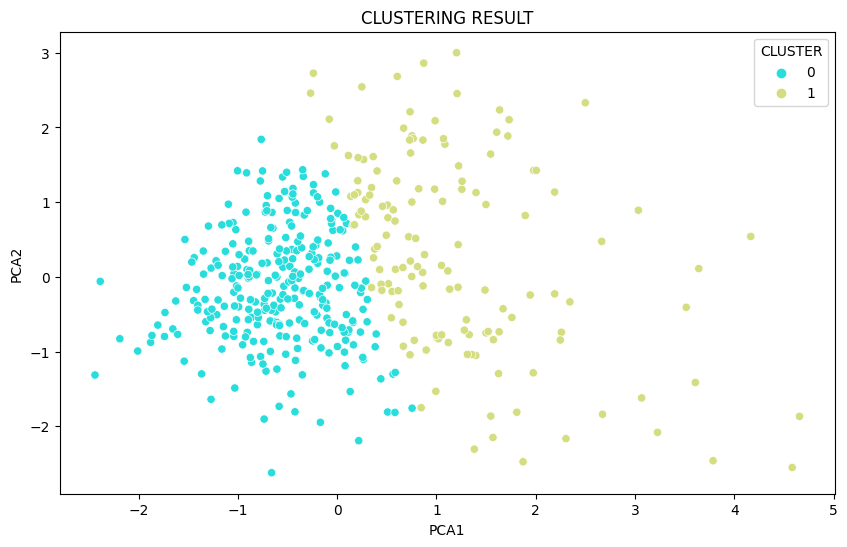


                 가중합
CLUSTER            
0        -33.494593
1        109.351774


In [ ]:
# K-means
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import RobustScaler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

# feature 형성
data = df.copy()
features = data[["월평균_승하차_승객수", "폭염빈도", "(초)미세먼지_나쁨빈도", "교통약자_인구수"]]
column_list = ["월평균_승하차_승객수", "폭염빈도", "(초)미세먼지_나쁨빈도", "교통약자_인구수"]

# 스케일러 적용 및 데이터 형성
scaler = RobustScaler()
scaled_features = scaler.fit_transform(features)
scaled_df = pd.DataFrame(scaled_features, columns=features.columns)

# 모델 정의 및 CLUSTER 컬럼 추가
num_clusters = 2
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
data["CLUSTER"] = kmeans.fit_predict(scaled_features)

# 가중치 부여 및 가중합 컬럼 추가
scaled_df["CLUSTER"] = kmeans.fit_predict(scaled_features)
scaled_df["월평균_승하차_승객수"] = scaled_df["월평균_승하차_승객수"]*0.4
scaled_df["폭염빈도"] = scaled_df["폭염빈도"]*0.2
scaled_df["(초)미세먼지_나쁨빈도"] = scaled_df["(초)미세먼지_나쁨빈도"]*0.2
scaled_df["교통약자_인구수"] = scaled_df["교통약자_인구수"]*0.2

scaled_df["가중합"] = scaled_df[column_list].sum(axis=1)
cluster_choose = scaled_df[["가중합", "CLUSTER"]].groupby("CLUSTER").sum()

# PCA를 사용하여 데이터 차원 축소
pca = PCA(n_components=2)
pca_result = pca.fit_transform(scaled_features)

data["PCA1"] = pca_result[:, 0]
data["PCA2"] = pca_result[:, 1]

plt.figure(figsize=(10, 6))
sns.scatterplot(data=data, x="PCA1", y="PCA2", hue="CLUSTER", palette="rainbow")
plt.xlabel("PCA1")
plt.ylabel("PCA2")
plt.title("CLUSTERING RESULT")
plt.show()
print("\n", cluster_choose)

In [ ]:
from sklearn.metrics import silhouette_score
from sklearn.metrics import pairwise_distances

# pairwise_distances 함수를 사용하여 모든 데이터 포인트 간의 거리 계산
distances = pairwise_distances(scaled_features)
cluster_labels = kmeans.predict(scaled_features)

# 변수 생성
intra_cluster_distances = []
inter_cluster_distances = []

# 클러스터내 거리 평균과 클러스터간 거리 평균 계산
for i in range(num_clusters):
    # 데이터 포인트를 선택하기 위한 마스크 생성 및 저장
    cluster_mask = cluster_labels == i
    cluster_data = scaled_df[cluster_mask]

    # 클러스터내 거리 계산
    intra_distance = distances[cluster_mask][:, cluster_mask].mean()
    intra_cluster_distances.append(intra_distance)

    # cluster_mask에 해당하는 행과 열만 선택하여 내부 거리 계산 후, 평균 계산 및 저장
    other_clusters_mask = cluster_labels != i
    other_clusters_data = scaled_df[other_clusters_mask]

    # 클러스터간 거리 계산
    inter_distance = distances[cluster_mask][:, other_clusters_mask].mean()
    inter_cluster_distances.append(inter_distance)

# 클러스터별 클러스터내 거리 평균과 클러스터간 거리 평균 출력
for i in range(num_clusters):
    print(f"Cluster {i}")
    print(f"  클러스터내 거리 평균: {intra_cluster_distances[i]:.4f}")
    print(f"  클러스터간 거리 평균: {inter_cluster_distances[i]:.4f}")

Cluster 0
  클러스터내 거리 평균: 1.6967
  클러스터간 거리 평균: 2.9007
Cluster 1
  클러스터내 거리 평균: 2.7833
  클러스터간 거리 평균: 2.9007


In [ ]:
# 클러스터 결정 및 행정동 목록 저장
kmeans_result = data[["자치구", "행정동", "CLUSTER"]].loc[data["CLUSTER"]==0]

kmeans_list = []
for i in kmeans_result["행정동"]:
    kmeans_list.append(i)

## Gaussian Mixture Mode

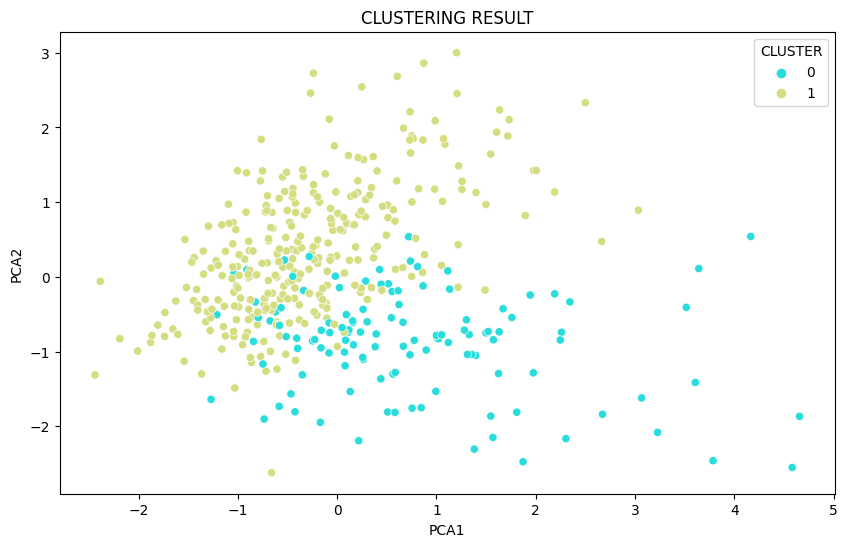


                가중합
CLUSTER           
0        73.273911
1         2.583270


In [ ]:
# Gaussian Mixture Model(GMM)
import pandas as pd
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import RobustScaler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

# feature 형성
data = df.copy()
features = data[["월평균_승하차_승객수", "폭염빈도", "(초)미세먼지_나쁨빈도", "교통약자_인구수"]]
column_list = ["월평균_승하차_승객수", "폭염빈도", "(초)미세먼지_나쁨빈도", "교통약자_인구수"]

# 스케일러 적용 및 데이터 형성
scaler = RobustScaler()
scaled_features = scaler.fit_transform(features)
scaled_df = pd.DataFrame(scaled_features, columns=features.columns)

# 모델 정의 및 CLUSTER 컬럼 추가
num_clusters = 2
gmm = GaussianMixture(n_components=num_clusters, random_state=42)
data["CLUSTER"] = gmm.fit_predict(scaled_features)
data["CLUSTER"] = gmm.fit_predict(scaled_df)

# 가중치 부여 및 가중합 컬럼 추가
scaled_df["CLUSTER"] = gmm.fit_predict(scaled_features)
scaled_df["월평균_승하차_승객수"] = scaled_df["월평균_승하차_승객수"]*0.4
scaled_df["폭염빈도"] = scaled_df["폭염빈도"]*0.2
scaled_df["(초)미세먼지_나쁨빈도"] = scaled_df["(초)미세먼지_나쁨빈도"]*0.2
scaled_df["교통약자_인구수"] = scaled_df["교통약자_인구수"]*0.2

scaled_df["가중합"] = scaled_df[column_list].sum(axis=1)
cluster_choose = scaled_df[["가중합", "CLUSTER"]].groupby("CLUSTER").sum()

# PCA를 사용하여 데이터 차원 축소
pca = PCA(n_components=2)
pca_result = pca.fit_transform(scaled_features)

data["PCA1"] = pca_result[:, 0]
data["PCA2"] = pca_result[:, 1]

plt.figure(figsize=(10, 6))
sns.scatterplot(data=data, x="PCA1", y="PCA2", hue="CLUSTER", palette="rainbow")
plt.xlabel("PCA1")
plt.ylabel("PCA2")
plt.title("CLUSTERING RESULT")
plt.show()
print("\n", cluster_choose)

In [ ]:
from sklearn.metrics import silhouette_score
from sklearn.metrics import pairwise_distances

# pairwise_distances 함수를 사용하여 모든 데이터 포인트 간의 거리 계산
distances = pairwise_distances(scaled_features)
cluster_labels = gmm.predict(scaled_features)

# 변수 생성
intra_cluster_distances = []
inter_cluster_distances = []

# 클러스터내 거리 평균과 클러스터간 거리 평균 계산
for i in range(num_clusters):
    # 데이터 포인트를 선택하기 위한 마스크 생성 및 저장
    cluster_mask = cluster_labels == i
    cluster_data = scaled_df[cluster_mask]

    # 클러스터내 거리 계산
    intra_distance = distances[cluster_mask][:, cluster_mask].mean()
    intra_cluster_distances.append(intra_distance)

    # cluster_mask에 해당하는 행과 열만 선택하여 내부 거리 계산 후, 평균 계산 및 저장
    other_clusters_mask = cluster_labels != i
    other_clusters_data = scaled_df[other_clusters_mask]

    # 클러스터간 거리 계산
    inter_distance = distances[cluster_mask][:, other_clusters_mask].mean()
    inter_cluster_distances.append(inter_distance)

# 클러스터별 클러스터내 거리 평균과 클러스터간 거리 평균 출력
for i in range(num_clusters):
    print(f"Cluster {i}")
    print(f"  클러스터내 거리 평균: {intra_cluster_distances[i]:.4f}")
    print(f"  클러스터간 거리 평균: {inter_cluster_distances[i]:.4f}")

Cluster 0
  클러스터내 거리 평균: 2.3956
  클러스터간 거리 평균: 2.7139
Cluster 1
  클러스터내 거리 평균: 2.0379
  클러스터간 거리 평균: 2.7139


In [ ]:
# 클러스터 결정 및 행정동 목록 저장
gaussian_result = data[["자치구", "행정동", "CLUSTER"]].loc[data["CLUSTER"]==1]

gaussian_list = []
for i in gaussian_result["행정동"]:
    gaussian_list.append(i)

## Hierarchical K-Means

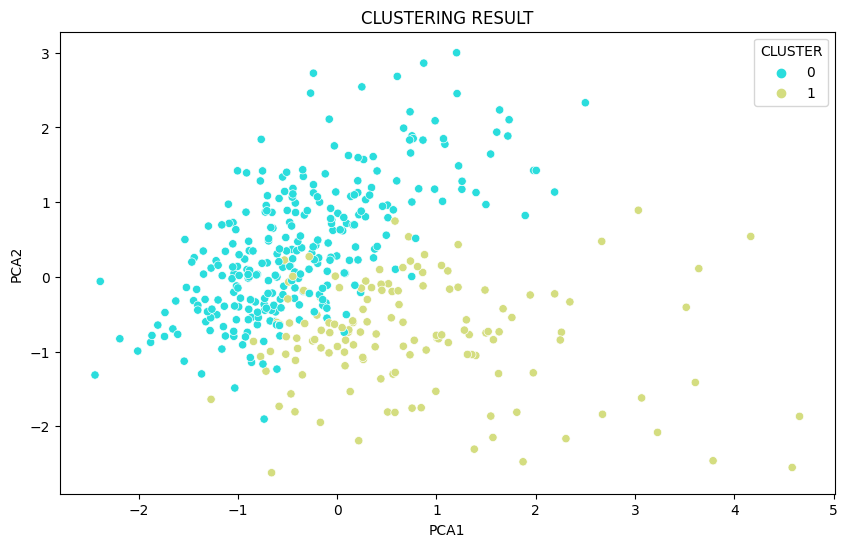


                가중합
CLUSTER           
0       -10.687816
1        86.544996


In [ ]:
# Hierarchical K-Means(HKMeans)
import pandas as pd
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import RobustScaler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

# feature 형성
data = df.copy()
features = data[["월평균_승하차_승객수", "폭염빈도", "(초)미세먼지_나쁨빈도", "교통약자_인구수"]]
column_list = ["월평균_승하차_승객수", "폭염빈도", "(초)미세먼지_나쁨빈도", "교통약자_인구수"]

# 스케일러 적용 및 데이터 형성
scaler = RobustScaler()
scaled_features = scaler.fit_transform(features)
scaled_df = pd.DataFrame(scaled_features, columns=features.columns)

# 모델 정의 및 CLUSTER 컬럼 추가
num_clusters = 2
hkmeans = AgglomerativeClustering(n_clusters=num_clusters)
data["CLUSTER"] = hkmeans.fit_predict(scaled_features)
data["CLUSTER"] = hkmeans.fit_predict(scaled_df)

# 가중치 부여 및 가중합 컬럼 추가
scaled_df["CLUSTER"] = hkmeans.fit_predict(scaled_features)
scaled_df["월평균_승하차_승객수"] = scaled_df["월평균_승하차_승객수"]*0.4
scaled_df["폭염빈도"] = scaled_df["폭염빈도"]*0.2
scaled_df["(초)미세먼지_나쁨빈도"] = scaled_df["(초)미세먼지_나쁨빈도"]*0.2
scaled_df["교통약자_인구수"] = scaled_df["교통약자_인구수"]*0.2

scaled_df["가중합"] = scaled_df[column_list].sum(axis=1)
cluster_choose = scaled_df[["가중합", "CLUSTER"]].groupby("CLUSTER").sum()

# PCA를 사용하여 데이터 차원 축소
pca = PCA(n_components=2)
pca_result = pca.fit_transform(scaled_features)

data["PCA1"] = pca_result[:, 0]
data["PCA2"] = pca_result[:, 1]

plt.figure(figsize=(10, 6))
sns.scatterplot(data=data, x="PCA1", y="PCA2", hue="CLUSTER", palette="rainbow")
plt.xlabel("PCA1")
plt.ylabel("PCA2")
plt.title("CLUSTERING RESULT")
plt.show()
print("\n", cluster_choose)

In [ ]:
from sklearn.metrics import silhouette_score
from sklearn.metrics import pairwise_distances

# pairwise_distances 함수를 사용하여 모든 데이터 포인트 간의 거리 계산
distances = pairwise_distances(scaled_features)
cluster_labels = hkmeans.fit_predict(scaled_features)

# 변수 생성
intra_cluster_distances = []
inter_cluster_distances = []

# 클러스터내 거리 평균과 클러스터간 거리 평균 계산
for i in range(num_clusters):
    # 데이터 포인트를 선택하기 위한 마스크 생성 및 저장
    cluster_mask = cluster_labels == i
    cluster_data = scaled_df[cluster_mask]

    # 클러스터내 거리 계산
    intra_distance = distances[cluster_mask][:, cluster_mask].mean()
    intra_cluster_distances.append(intra_distance)

    # cluster_mask에 해당하는 행과 열만 선택하여 내부 거리 계산 후, 평균 계산 및 저장
    other_clusters_mask = cluster_labels != i
    other_clusters_data = scaled_df[other_clusters_mask]

    # 클러스터간 거리 계산
    inter_distance = distances[cluster_mask][:, other_clusters_mask].mean()
    inter_cluster_distances.append(inter_distance)

# 클러스터별 클러스터내 거리 평균과 클러스터간 거리 평균 출력
for i in range(num_clusters):
    print(f"Cluster {i}")
    print(f"  클러스터내 거리 평균: {intra_cluster_distances[i]:.4f}")
    print(f"  클러스터간 거리 평균: {inter_cluster_distances[i]:.4f}")

Cluster 0
  클러스터내 거리 평균: 1.9866
  클러스터간 거리 평균: 2.6993
Cluster 1
  클러스터내 거리 평균: 2.3630
  클러스터간 거리 평균: 2.6993


In [ ]:
# 클러스터 결정 및 행정동 목록 저장
hkmeans_result = data[["자치구", "행정동", "CLUSTER"]].loc[data["CLUSTER"]==0]

hkmeans_list = []
for i in hkmeans_result["행정동"]:
    hkmeans_list.append(i)

## K-Medoids

In [ ]:
!pip install scikit-learn-extra

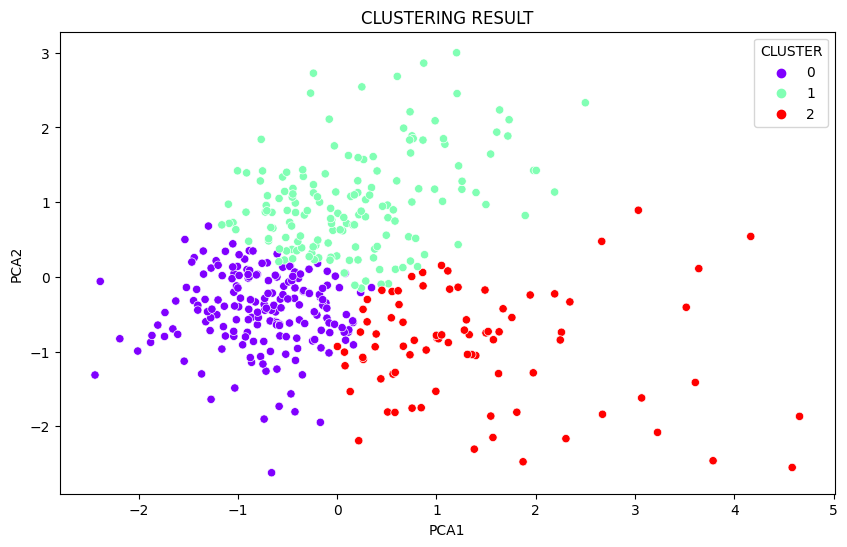


                가중합
CLUSTER           
0       -35.404320
1        34.544447
2        76.717054


In [ ]:
# K-Medoids
import pandas as pd
from sklearn_extra.cluster import KMedoids
from sklearn.preprocessing import RobustScaler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

# feature 형성
data = df.copy()
features = data[["월평균_승하차_승객수", "폭염빈도", "(초)미세먼지_나쁨빈도", "교통약자_인구수"]]
column_list = ["월평균_승하차_승객수", "폭염빈도", "(초)미세먼지_나쁨빈도", "교통약자_인구수"]

# 스케일러 적용 및 데이터 형성
scaler = RobustScaler()
scaled_features = scaler.fit_transform(features)
scaled_df = pd.DataFrame(scaled_features, columns=features.columns)

# 모델 정의 및 CLUSTER 컬럼 추가
num_clusters = 3
kmedoids = KMedoids(n_clusters=num_clusters, random_state=42)
data["CLUSTER"] = kmedoids.fit_predict(scaled_features)

# 가중치 부여 및 가중합 컬럼 추가
scaled_df["CLUSTER"] = kmedoids.fit_predict(scaled_features)
scaled_df["월평균_승하차_승객수"] = scaled_df["월평균_승하차_승객수"]*0.4
scaled_df["폭염빈도"] = scaled_df["폭염빈도"]*0.2
scaled_df["(초)미세먼지_나쁨빈도"] = scaled_df["(초)미세먼지_나쁨빈도"]*0.2
scaled_df["교통약자_인구수"] = scaled_df["교통약자_인구수"]*0.2

scaled_df["가중합"] = scaled_df[column_list].sum(axis=1)
cluster_choose = scaled_df[["가중합", "CLUSTER"]].groupby("CLUSTER").sum()

# PCA를 사용하여 데이터 차원 축소
pca = PCA(n_components=2)
pca_result = pca.fit_transform(scaled_features)

data["PCA1"] = pca_result[:, 0]
data["PCA2"] = pca_result[:, 1]

plt.figure(figsize=(10, 6))
sns.scatterplot(data=data, x="PCA1", y="PCA2", hue="CLUSTER", palette="rainbow")
plt.xlabel("PCA1")
plt.ylabel("PCA2")
plt.title("CLUSTERING RESULT")
plt.show()
print("\n", cluster_choose)

In [ ]:
from sklearn.metrics import silhouette_score
from sklearn.metrics import pairwise_distances

# pairwise_distances 함수를 사용하여 모든 데이터 포인트 간의 거리 계산
distances = pairwise_distances(scaled_features)
cluster_labels = kmedoids.predict(scaled_features)

# 변수 생성
intra_cluster_distances = []
inter_cluster_distances = []

# 클러스터내 거리 평균과 클러스터간 거리 평균 계산
for i in range(num_clusters):
    # 데이터 포인트를 선택하기 위한 마스크 생성 및 저장
    cluster_mask = cluster_labels == i
    cluster_data = scaled_df[cluster_mask]

    # 클러스터내 거리 계산
    intra_distance = distances[cluster_mask][:, cluster_mask].mean()
    intra_cluster_distances.append(intra_distance)

    # cluster_mask에 해당하는 행과 열만 선택하여 내부 거리 계산 후, 평균 계산 및 저장
    other_clusters_mask = cluster_labels != i
    other_clusters_data = scaled_df[other_clusters_mask]

    # 클러스터간 거리 계산
    inter_distance = distances[cluster_mask][:, other_clusters_mask].mean()
    inter_cluster_distances.append(inter_distance)

# 클러스터별 클러스터내 거리 평균과 클러스터간 거리 평균 출력
for i in range(num_clusters):
    print(f"Cluster {i}")
    print(f"  클러스터내 거리 평균: {intra_cluster_distances[i]:.4f}")
    print(f"  클러스터간 거리 평균: {inter_cluster_distances[i]:.4f}")

Cluster 0
  클러스터내 거리 평균: 1.4769
  클러스터간 거리 평균: 2.5414
Cluster 1
  클러스터내 거리 평균: 1.9811
  클러스터간 거리 평균: 2.6048
Cluster 2
  클러스터내 거리 평균: 2.4204
  클러스터간 거리 평균: 3.0015


In [ ]:
# 클러스터 결정 및 행정동 목록 저장
kmedoids_result = data[["자치구", "행정동", "CLUSTER"]].loc[data["CLUSTER"]==0]

kmedoids_list = []
for i in kmedoids_result["행정동"]:
    kmedoids_list.append(i)

## 결과 추출

In [ ]:
# 각 모델의 결정된 클러스터의 공통 행정동 추출
elements = set(kmeans_list) & set(gaussian_list) & set(hkmeans_list) & set(kmedoids_list)
result = list(elements)

# 데이터 내에서 확인
result_df = df[df["행정동"].isin(result)]

In [ ]:
# feature 형성
feature = ["월평균_승하차_승객수", "폭염빈도", "(초)미세먼지_나쁨빈도", "교통약자_인구수"]

# 스케일러 적용 및 데이터 형성
scaler = RobustScaler()
result_df[feature] = scaler.fit_transform(result_df[feature])

# 가중치 부여 및 가중합 컬럼 추가
result_df["월평균_승하차_승객수"] = result_df["월평균_승하차_승객수"]*0.4
result_df["폭염빈도"] = result_df["폭염빈도"]*0.2
result_df["(초)미세먼지_나쁨빈도"] = result_df["(초)미세먼지_나쁨빈도"]*0.2
result_df["교통약자_인구수"] = result_df["교통약자_인구수"]*0.2

result_df["가중합"] = result_df[feature].sum(axis=1)

# 가중합 기준 상위 30개 추출
final_df = result_df.sort_values(by="가중합", ascending=True).head(30)
name = final_df[["자치구", "행정동"]]
final = pd.merge(name, df, on=["자치구", "행정동"])
final

<ipython-input-182-dbf226c1d17c>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_df[feature] = scaler.fit_transform(result_df[feature])
<ipython-input-182-dbf226c1d17c>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_df["월평균_승하차_승객수"] = result_df["월평균_승하차_승객수"]*0.4
<ipython-input-182-dbf226c1d17c>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https:

,자치구,행정동,월평균_승하차_승객수,폭염빈도,(초)미세먼지_나쁨빈도,교통약자_인구수
0,강동구,둔촌1동,27587.0,21,39,9
1,강동구,암사3동,61724.0,12,17,5416
2,중구,신당동,262563.0,2,171,1999
3,구로구,항동,40500.0,18,26,5220
4,강남구,개포3동,91614.0,4,191,5679
5,송파구,잠실7동,199788.0,15,119,3077
6,강동구,명일2동,163177.0,16,73,4680
7,노원구,상계8동,77173.0,19,69,6170
8,중구,황학동,114550.0,20,162,3121
9,강서구,가양2동,148219.0,18,67,6046


In [ ]:
# 유동인구 기준 상위 4개 행정동 확인 (자양 4동은 시험 운영지역으로 제외)
final.sort_values(by="월평균_승하차_승객수", ascending=False).head(4)

,자치구,행정동,월평균_승하차_승객수,폭염빈도,(초)미세먼지_나쁨빈도,교통약자_인구수
24,광진구,자양4동,369067.0,19,30,5055
20,광진구,능동,353184.0,25,48,2507
28,동대문구,회기동,335095.0,24,119,2243
29,용산구,이태원2동,292301.0,29,80,2344


In [ ]:
# 폭염빈도 기준 상위 3개 행정동 확인
final.sort_values(by="폭염빈도", ascending=False).head(3)

,자치구,행정동,월평균_승하차_승객수,폭염빈도,(초)미세먼지_나쁨빈도,교통약자_인구수
11,중구,동화동,52842.0,33,55,3025
17,마포구,염리동,16498.0,31,119,4205
29,용산구,이태원2동,292301.0,29,80,2344


In [ ]:
# 미세먼지 기준 상위 3개 행정동 확인
final.sort_values(by="(초)미세먼지_나쁨빈도", ascending=False).head(3)

,자치구,행정동,월평균_승하차_승객수,폭염빈도,(초)미세먼지_나쁨빈도,교통약자_인구수
4,강남구,개포3동,91614.0,4,191,5679
2,중구,신당동,262563.0,2,171,1999
12,영등포구,신길4동,190069.0,16,170,3779


In [ ]:
# 교통약자 기준 상위 3개 행정동 확인
final.sort_values(by="교통약자_인구수", ascending=False).head(3)

,자치구,행정동,월평균_승하차_승객수,폭염빈도,(초)미세먼지_나쁨빈도,교통약자_인구수
19,송파구,잠실4동,175712.0,23,31,6605
16,강북구,미아동,52329.0,25,84,6198
7,노원구,상계8동,77173.0,19,69,6170
